In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# All the needed preprocessing 

# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.

application_df.drop(['EIN','NAME'], axis = 1, inplace=True)

application_type_counts = application_df.value_counts(['APPLICATION_TYPE'])

# Determine which values to replace if counts are less than 500
replace_application = list(application_type_counts[application_type_counts < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")

classification_counts = application_df.value_counts(['CLASSIFICATION'])

replace_classification = list(classification_counts[classification_counts < 1000].index)

# Replace in dataframe
for cls in replace_classification:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")

# Generate our categorical variable lists

application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)


# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True, right_index = True)
application_df = application_df.drop(application_cat,1)





/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [3]:
# Split our preprocessed data into our features and target arrays

y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [4]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [5]:
print(len(X_train[0]))

43


In [6]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 6
hidden_nodes_layer2 = 3

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 264       
                                                                 
 dense_1 (Dense)             (None, 3)                 21        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [8]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5000)

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs = 100, callbacks=[cp_callback])

In [10]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5631 - accuracy: 0.7255 - 886ms/epoch - 3ms/step
Loss: 0.5630664229393005, Accuracy: 0.7254810333251953


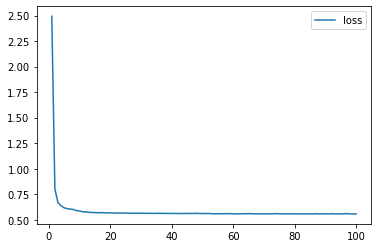

In [11]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

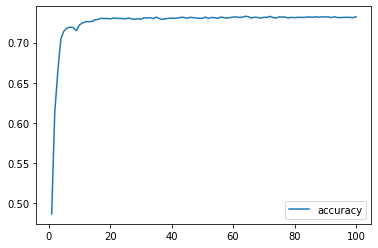

In [12]:
# Plot the accuracy
history_df.plot(y="accuracy")

In [13]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
m2_number_input_features = len(X_train[0])
m2_hidden_nodes_layer1 = 12
m2_hidden_nodes_layer2 = 8

nn2 = tf.keras.models.Sequential()

# First hidden layer
nn2.add(
    tf.keras.layers.Dense(units=m2_hidden_nodes_layer1, input_dim=m2_number_input_features, activation="relu")
)

# Second hidden layer
nn2.add(tf.keras.layers.Dense(units=m2_hidden_nodes_layer2, activation="relu"))

# Output layer
nn2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5000)

# Compile the model
nn2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [15]:
# Train the model
fit_model = nn2.fit(X_train_scaled, y_train, epochs = 100, callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 2s 2ms/step - loss: 0.6122 - accuracy: 0.6836
Epoch 2/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5657 - accuracy: 0.7225
Epoch 3/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5588 - accuracy: 0.7290
Epoch 4/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5561 - accuracy: 0.7312
Epoch 5/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5550 - accuracy: 0.7324
Epoch 6/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5539 - accuracy: 0.7320
Epoch 7/100
156/804 [====>.........................] - ETA: 1s - loss: 0.5624 - accuracy: 0.7288
Epoch 7: saving model to checkpoints/weights.07.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5531 - accuracy: 0.7324
Epoch 8/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5523 - accuracy: 0.7323
Epoch 9/100
804/804 [==============================] -

In [16]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5511 - accuracy: 0.7266 - 443ms/epoch - 2ms/step
Loss: 0.5510823130607605, Accuracy: 0.7266472578048706


In [17]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
m3_number_input_features = len(X_train[0])
m3_hidden_nodes_layer1 = 8
m3_hidden_nodes_layer2 = 6
m3_hidden_nodes_layer3 = 4


nn3 = tf.keras.models.Sequential()

# First hidden layer
nn3.add(
    tf.keras.layers.Dense(units=m3_hidden_nodes_layer1, input_dim=m3_number_input_features, activation="sigmoid")
)

# Second hidden layer
nn3.add(tf.keras.layers.Dense(units=m3_hidden_nodes_layer2, activation="relu"))

# Third Hidden Layer

nn3.add(tf.keras.layers.Dense(units=m3_hidden_nodes_layer3, activation="relu"))

# Output layer
nn3.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 352       
                                                                 
 dense_7 (Dense)             (None, 6)                 54        
                                                                 
 dense_8 (Dense)             (None, 4)                 28        
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 439
Trainable params: 439
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5000)

# Compile the model
nn3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model = nn3.fit(X_train_scaled, y_train, epochs = 100, callbacks=[cp_callback])

In [21]:
#new dataframe for last model attempt
application_df2 = pd.read_csv("charity_data.csv")
application_df2.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [20]:
# Evaluate model 3 using the test data
model_loss, model_accuracy = nn3.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5524 - accuracy: 0.7280 - 1s/epoch - 4ms/step
Loss: 0.552444338798523, Accuracy: 0.7280466556549072


In [24]:
name_count = application_df2['NAME'].value_counts()

In [27]:
# How many names had below 10 instances?

len(list(name_count[name_count <=10].index))

19364

In [28]:
# Cut off any names below 10 instances

replace_name = list(name_count[name_count <= 10].index)

# Replace in dataframe
for name in replace_name:
  application_df2.NAME = application_df2.NAME.replace(name,"Other")


#Check to see if binning worked

application_df2.NAME.value_counts()

Other                                                                     21202
PARENT BOOSTER USA INC                                                     1260
TOPS CLUB INC                                                               765
UNITED STATES BOWLING CONGRESS INC                                          700
WASHINGTON STATE UNIVERSITY                                                 492
                                                                          ...  
AMERICAN POSTAL WORKERS UNION                                                11
SOCIETY FOR PRESERVATION & ENCOURMT OF BARBERSHOP QUARTET SINGING AMER       11
SIGMA ALPHA OMEGA CHRISTIAN SORORITY INC                                     11
FINANCIAL PLANNING ASSOCIATION                                               11
SLOW FOOD U S A INC                                                          11
Name: NAME, Length: 205, dtype: int64

In [29]:
# Look at Application_type value counts for binning

application_type_counts2 = application_df2.value_counts(['APPLICATION_TYPE'])
application_type_counts2

APPLICATION_TYPE
T3                  27037
T4                   1542
T6                   1216
T5                   1173
T19                  1065
T8                    737
T7                    725
T10                   528
T9                    156
T13                    66
T12                    27
T2                     16
T14                     3
T25                     3
T29                     2
T15                     2
T17                     1
dtype: int64

In [30]:
# Replace any application type with less than 50 instances

replace_application = list(application_type_counts2[application_type_counts2 < 50].index)

# Replace in dataframe
for app in replace_application:
    application_df2.APPLICATION_TYPE = application_df2.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df2.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
T9         156
T13         66
Other       54
Name: APPLICATION_TYPE, dtype: int64

In [32]:
# Look at CLASSIFICATION value counts for binning
classification_counts2 = application_df2.value_counts(['CLASSIFICATION'])
classification_counts2

CLASSIFICATION
C1000             17326
C2000              6074
C1200              4837
C3000              1918
C2100              1883
                  ...  
C2190                 1
C2380                 1
C2500                 1
C2561                 1
C8210                 1
Length: 71, dtype: int64

In [33]:
# Determine which values to replace if counts are less than 50
replace_classification = list(classification_counts2[classification_counts2 < 50].index)

# Replace in dataframe
for cls in replace_classification:
    application_df2.CLASSIFICATION = application_df2.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df2.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
Other      391
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
Name: CLASSIFICATION, dtype: int64

In [34]:
# Generate our categorical variable lists

application_cat2 = application_df2.dtypes[application_df2.dtypes == "object"].index.tolist()
application_cat2

['NAME',
 'APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [35]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df2 = pd.DataFrame(enc.fit_transform(application_df2[application_cat2]))

# Add the encoded variable names to the dataframe
encode_df2.columns = enc.get_feature_names(application_cat2)
encode_df2.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,NAME_ALTRUSA INTERNATIONAL FOUNDATION INC,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,NAME_AMERICAN ART THERAPY ASSOCIATION INC,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [36]:
# Merge one-hot encoded features and drop the originals
application_df2 = application_df2.merge(encode_df2,left_index=True, right_index = True)
application_df2 = application_df2.drop(application_cat2,1)
application_df2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,EIN,STATUS,ASK_AMT,IS_SUCCESSFUL,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,10520599,1,5000,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,10531628,1,108590,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,10547893,1,5000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,10553066,1,6692,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,10556103,1,142590,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [40]:
# Drop EIN Column, not needed in last model

application_df2.drop(["EIN"], axis = 1, inplace=True)

In [41]:
# Split our preprocessed data into our features and target arrays

y = application_df2["IS_SUCCESSFUL"].values
X = application_df2.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [42]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [46]:
#Define last model

m4number_input_features = len(X_train[0])
m4hidden_nodes_layer1 = 8
m4hidden_nodes_layer2 = 6
m4hidden_nodes_layer3 = 4

nn4 = tf.keras.models.Sequential()

# First hidden layer
nn4.add(
    tf.keras.layers.Dense(units=m4hidden_nodes_layer1, input_dim=m4number_input_features, activation="sigmoid")
)

# Second hidden layer
nn4.add(tf.keras.layers.Dense(units=m4hidden_nodes_layer2, activation="relu"))

# Third Hidden layer 

nn4.add(tf.keras.layers.Dense(units=m4hidden_nodes_layer3, activation="sigmoid"))

# Output layer
nn4.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 8)                 2088      
                                                                 
 dense_14 (Dense)            (None, 6)                 54        
                                                                 
 dense_15 (Dense)            (None, 4)                 28        
                                                                 
 dense_16 (Dense)            (None, 1)                 5         
                                                                 
Total params: 2,175
Trainable params: 2,175
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [48]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5000)

# Compile the model
nn4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [50]:
# Train the model
fit_model = nn4.fit(X_train_scaled, y_train, epochs = 200, callbacks=[cp_callback])

Epoch 1/200
804/804 [==============================] - 4s 4ms/step - loss: 0.5945 - accuracy: 0.6777
Epoch 2/200
804/804 [==============================] - 3s 4ms/step - loss: 0.4842 - accuracy: 0.7816
Epoch 3/200
804/804 [==============================] - 2s 3ms/step - loss: 0.4709 - accuracy: 0.7842
Epoch 4/200
804/804 [==============================] - 2s 2ms/step - loss: 0.4637 - accuracy: 0.7828
Epoch 5/200
804/804 [==============================] - 2s 2ms/step - loss: 0.4587 - accuracy: 0.7830
Epoch 6/200
804/804 [==============================] - 2s 2ms/step - loss: 0.4550 - accuracy: 0.7801
Epoch 7/200
162/804 [=====>........................] - ETA: 1s - loss: 0.4566 - accuracy: 0.7793
Epoch 7: saving model to checkpoints/weights.07.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.4518 - accuracy: 0.7831
Epoch 8/200
804/804 [==============================] - 2s 2ms/step - loss: 0.4495 - accuracy: 0.7825
Epoch 9/200
804/804 [==============================] -

In [51]:
# Evaluate model 4 using the test data
model_loss, model_accuracy = nn4.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.4548 - accuracy: 0.7805 - 955ms/epoch - 4ms/step
Loss: 0.45483365654945374, Accuracy: 0.7805247902870178


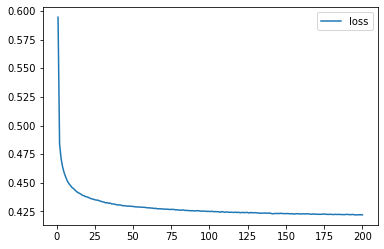

In [53]:
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

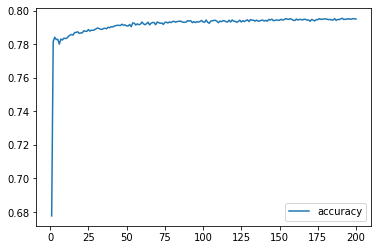

In [54]:
# Plot the accuracy
history_df.plot(y="accuracy")

In [55]:
!zip -r /content/checkpoints.zip /content/checkpoints

  adding: content/checkpoints/ (stored 0%)
  adding: content/checkpoints/weights.63.hdf5 (deflated 66%)
  adding: content/checkpoints/weights.56.hdf5 (deflated 66%)
  adding: content/checkpoints/weights.168.hdf5 (deflated 66%)
  adding: content/checkpoints/weights.187.hdf5 (deflated 66%)
  adding: content/checkpoints/weights.144.hdf5 (deflated 66%)
  adding: content/checkpoints/weights.44.hdf5 (deflated 66%)
  adding: content/checkpoints/weights.13.hdf5 (deflated 66%)
  adding: content/checkpoints/weights.137.hdf5 (deflated 66%)
  adding: content/checkpoints/weights.07.hdf5 (deflated 66%)
  adding: content/checkpoints/weights.38.hdf5 (deflated 66%)
  adding: content/checkpoints/weights.150.hdf5 (deflated 66%)
  adding: content/checkpoints/weights.88.hdf5 (deflated 66%)
  adding: content/checkpoints/weights.106.hdf5 (deflated 66%)
  adding: content/checkpoints/weights.162.hdf5 (deflated 66%)
  adding: content/checkpoints/weights.175.hdf5 (deflated 66%)
  adding: content/checkpoints/weig